# 📘 Sentiment Analysis on Amazon Product Reviews  
**By Michael Yassa**

This project builds a clean and interpretable sentiment classifier to determine whether an Amazon review is **positive** or **negative** using traditional NLP techniques. We apply text preprocessing, TF-IDF feature extraction, and train a Logistic Regression model.

---

## 🎯 Objectives

- Preprocess and clean review text
- Convert text into numerical features (TF-IDF)
- Train and evaluate a Logistic Regression classifier
- Measure performance on training, validation, and test sets
- Provide an interactive UI for custom sentiment prediction

---

## 📦 Dataset Overview

We use Amazon product review data provided in `fastText` format, with two files:

- `train.ft.txt.bz2` — training data
- `test.ft.txt.bz2` — test data

Each line in the dataset follows this structure:

__label__2 Great product! Works perfectly.


Labels:
- `__label__1` = Negative (1–2 stars)
- `__label__2` = Positive (4–5 stars)

Neutral (3-star) reviews were excluded for clarity.

---

## 🛠️ Tools & Libraries

- **Data Handling:** `pandas`, `numpy`, `bz2`, `os`
- **Text Processing:** `re`, `nltk` (stopwords), optional stemming
- **Feature Extraction:** `TfidfVectorizer` (`scikit-learn`)
- **Modeling & Evaluation:** `LogisticRegression`, metrics, `confusion_matrix`
- **Visualization:** `matplotlib`, `seaborn`
- **Interactive Input:** `ipywidgets` (optional)

---

> **Author:** Michael Yassa


**Getting rid of warnings**

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [62]:
# 📚 Importing Required Libraries

# Data handling
import pandas as pd
import numpy as np
import bz2
import os
import re
import gc

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from sklearn.utils import shuffle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Optional: UI widget for manual testing
import ipywidgets as widgets
from IPython.display import display


## 📌 Step 1: Load Compressed Amazon Review Dataset

This step reads the Amazon review dataset in `.bz2` compressed format. 
Each line contains a label (`__label__1` or `__label__2`) followed by a review comment.

- `__label__2` → 1 (Positive)
- `__label__1` → 0 (Negative)

The function `assign_labels_and_comments` parses the labels and review texts,
returning:
- A NumPy array of labels
- A list of corresponding review texts

The dataset used is the large-scale Amazon Reviews from [Kaggle](https://www.kaggle.com/datasets/bittlingmayer/amazonreviews).


In [49]:
def assign_labels_and_comments(filepath):
    labels, comments = [], []
    with bz2.BZ2File(filepath, 'r') as file:
        for line in file:
            line = line.decode("utf-8")
            label = int(line[9]) - 1  # __label__1 or __label__2 → 0/1
            comment = line[10:].strip()
            labels.append(label)
            comments.append(comment)
    
    return np.array(labels), comments

# Load datasets
train_labels, train_comments = assign_labels_and_comments('/kaggle/input/amazonreviews/train.ft.txt.bz2')
test_labels, test_comments = assign_labels_and_comments('/kaggle/input/amazonreviews/test.ft.txt.bz2')

print(f"Training samples: {len(train_comments)}, Test samples: {len(test_comments)}")


Training samples: 3600000, Test samples: 400000


## 📌 Step 2: Text Preprocessing

We clean the review texts using the following steps:

1. **Lowercasing** – Convert all text to lowercase for uniformity.
2. **Remove Punctuation & Symbols** – Strip all non-word characters using regex.
3. **Remove Non-ASCII characters** – Removes accented characters and symbols.
4. **Remove Stop Words** – Removes common English words like "the", "and", "is".

We use `nltk`'s English stopwords and apply the cleaning to all training, validation, and testing data.


In [50]:

not_alphanumeric = re.compile(r'[\W]')
not_ascii = re.compile(r'[^a-z0-9\s]')  # Fixed 0-1 → 0-9

def preprocess_texts(texts):
    """
    Normalize text by:
    1. Lowercasing
    2. Removing punctuation
    3. Removing non-ASCII characters
    """
    processed = []
    for text in texts:
        lower = text.lower()
        no_punctuation = not_alphanumeric.sub(' ', lower)
        no_non_ascii = not_ascii.sub('', no_punctuation)
        processed.append(no_non_ascii)
    return processed

# Apply preprocessing
train_comments = preprocess_texts(train_comments)
test_comments = preprocess_texts(test_comments)


## 📌 Step 3: Split Training Data into Train and Validation Sets

After cleaning the full training data, we split it into:

- **Training set (80%)** for learning
- **Validation set (20%)** for tuning and intermediate evaluation

We use `sklearn.model_selection.train_test_split()` with a fixed `random_state` to ensure reproducibility.

> 🔒 Note: The test set is **not split**. It's reserved for final model evaluation and must remain untouched during training.


In [51]:
train_comments, val_comments, train_labels, val_labels = train_test_split(
    train_comments,
    train_labels,
    test_size=0.2,
    random_state=42
)

## 📌 Step 4: Stemming and Feature Extraction

We apply **Porter Stemming** to reduce words to their base/root forms (e.g., "running" → "run") before feature extraction. This helps reduce vocabulary size and focuses on core word meaning.

Then, we use **TF-IDF (Term Frequency-Inverse Document Frequency)** to convert the stemmed text into numerical vectors for model training.

TF-IDF helps assign more weight to unique, meaningful words across documents.


In [ ]:
stemmer = PorterStemmer()

def stem_text(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)

def apply_stemming(texts):
    return [stem_text(comment) for comment in texts]

# ✅ Apply stemming to all comments (before vectorization)
train_comments = apply_stemming(train_comments)
val_comments = apply_stemming(val_comments)
test_comments = apply_stemming(test_comments)


In [53]:
# ✅ Create and fit vectorizer
vectorizer = TfidfVectorizer()

# ✅ Transform comments to feature vectors
X_train = vectorizer.fit_transform(train_comments)
X_val = vectorizer.transform(val_comments)
X_test = vectorizer.transform(test_comments)


## 📌 Step 6: Model Training & Evaluation

We train a Logistic Regression model on the TF-IDF vectors from the training data.

Unlike neural networks, logistic regression is trained in a **single pass** using optimization. There is **no need for epochs or shuffling**.

We evaluate the model using:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**

We also visualize the confusion matrix on the validation set.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 21 epochs took 104 seconds
📊 Train Metrics:
  Accuracy : 0.9186
  Precision: 0.9179
  Recall   : 0.9194
  F1 Score : 0.9186

📊 Validation Metrics:
  Accuracy : 0.9122
  Precision: 0.9114
  Recall   : 0.9133
  F1 Score : 0.9123



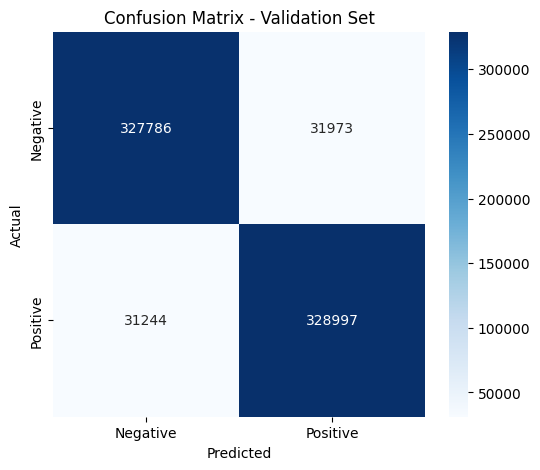

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# 1. Define the Logistic Regression model
log_reg = LogisticRegression(
    solver='saga',         # Better for sparse data
    penalty='l2',
    max_iter=1000,
    random_state=42,
    n_jobs=-1,             # Use all available CPU cores
    verbose=1              # See progress
)


# 2. Fit the model on the training data
log_reg.fit(X_train, train_labels)

# 3. Predict on training and validation sets
train_preds = log_reg.predict(X_train)
val_preds = log_reg.predict(X_val)

# 4. Calculate performance metrics
def print_metrics(y_true, y_pred, dataset_name=""):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"📊 {dataset_name} Metrics:")
    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1 Score : {f1:.4f}\n")

print_metrics(train_labels, train_preds, "Train")
print_metrics(val_labels, val_preds, "Validation")

# 5. Plot Confusion Matrix for Validation Set
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Set")
plt.show()


## 🧪 Step 7: Test Set Evaluation

We now evaluate the trained model on the **held-out test set**, which was not used during training or validation.

This provides a realistic estimate of the model’s performance in real-world scenarios.

We also include a confusion matrix to visualize classification errors.


📊 Test Metrics:
  Accuracy : 0.9120
  Precision: 0.9110
  Recall   : 0.9131
  F1 Score : 0.9121



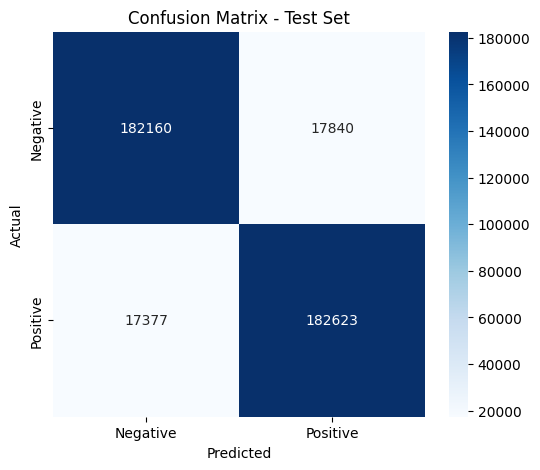

In [60]:
# 6. Predict on test set
test_preds = log_reg.predict(X_test)

# 7. Print test metrics
print_metrics(test_labels, test_preds, "Test")

# 8. Plot Confusion Matrix for Test Set
cm_test = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.show()


In [61]:
def predict_sentiment(text):
    # Preprocess text the same way as training data
    text_clean = preprocess_texts([text])  # apply your cleaning function
    text_clean = [remove_stop_words(comment) for comment in text_clean]
    # text_clean = apply_stemming(text_clean)  # Uncomment if you stemmed your training set

    # Vectorize and predict
    vec = vectorizer.transform(text_clean)
    prediction = log_reg.predict(vec)[0]
    label = "Positive 😊" if prediction == 1 else "Negative 😠"
    print(f"\nPrediction: {label}")

# Create a simple widget
text_input = widgets.Text(
    value='This phone is amazing!',
    placeholder='Type your review here...',
    description='Input:',
    layout=widgets.Layout(width='600px')
)

button = widgets.Button(description="Predict Sentiment")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        predict_sentiment(text_input.value)

button.on_click(on_button_clicked)

display(text_input, button, output)


Text(value='This phone is amazing!', description='Input:', layout=Layout(width='600px'), placeholder='Type you…

Button(description='Predict Sentiment', style=ButtonStyle())

Output()